Found 10 images in 'Photos' directory

[1/10] Processing: 1.jpg
[2/10] Processing: 10.jpg
[3/10] Processing: 2.jpg
[4/10] Processing: 3.jpg
[5/10] Processing: 4.jpg
[6/10] Processing: 5.jpg
[7/10] Processing: 6.jpg
[8/10] Processing: 7.jpg
[9/10] Processing: 8.jpg
[10/10] Processing: 9.jpg


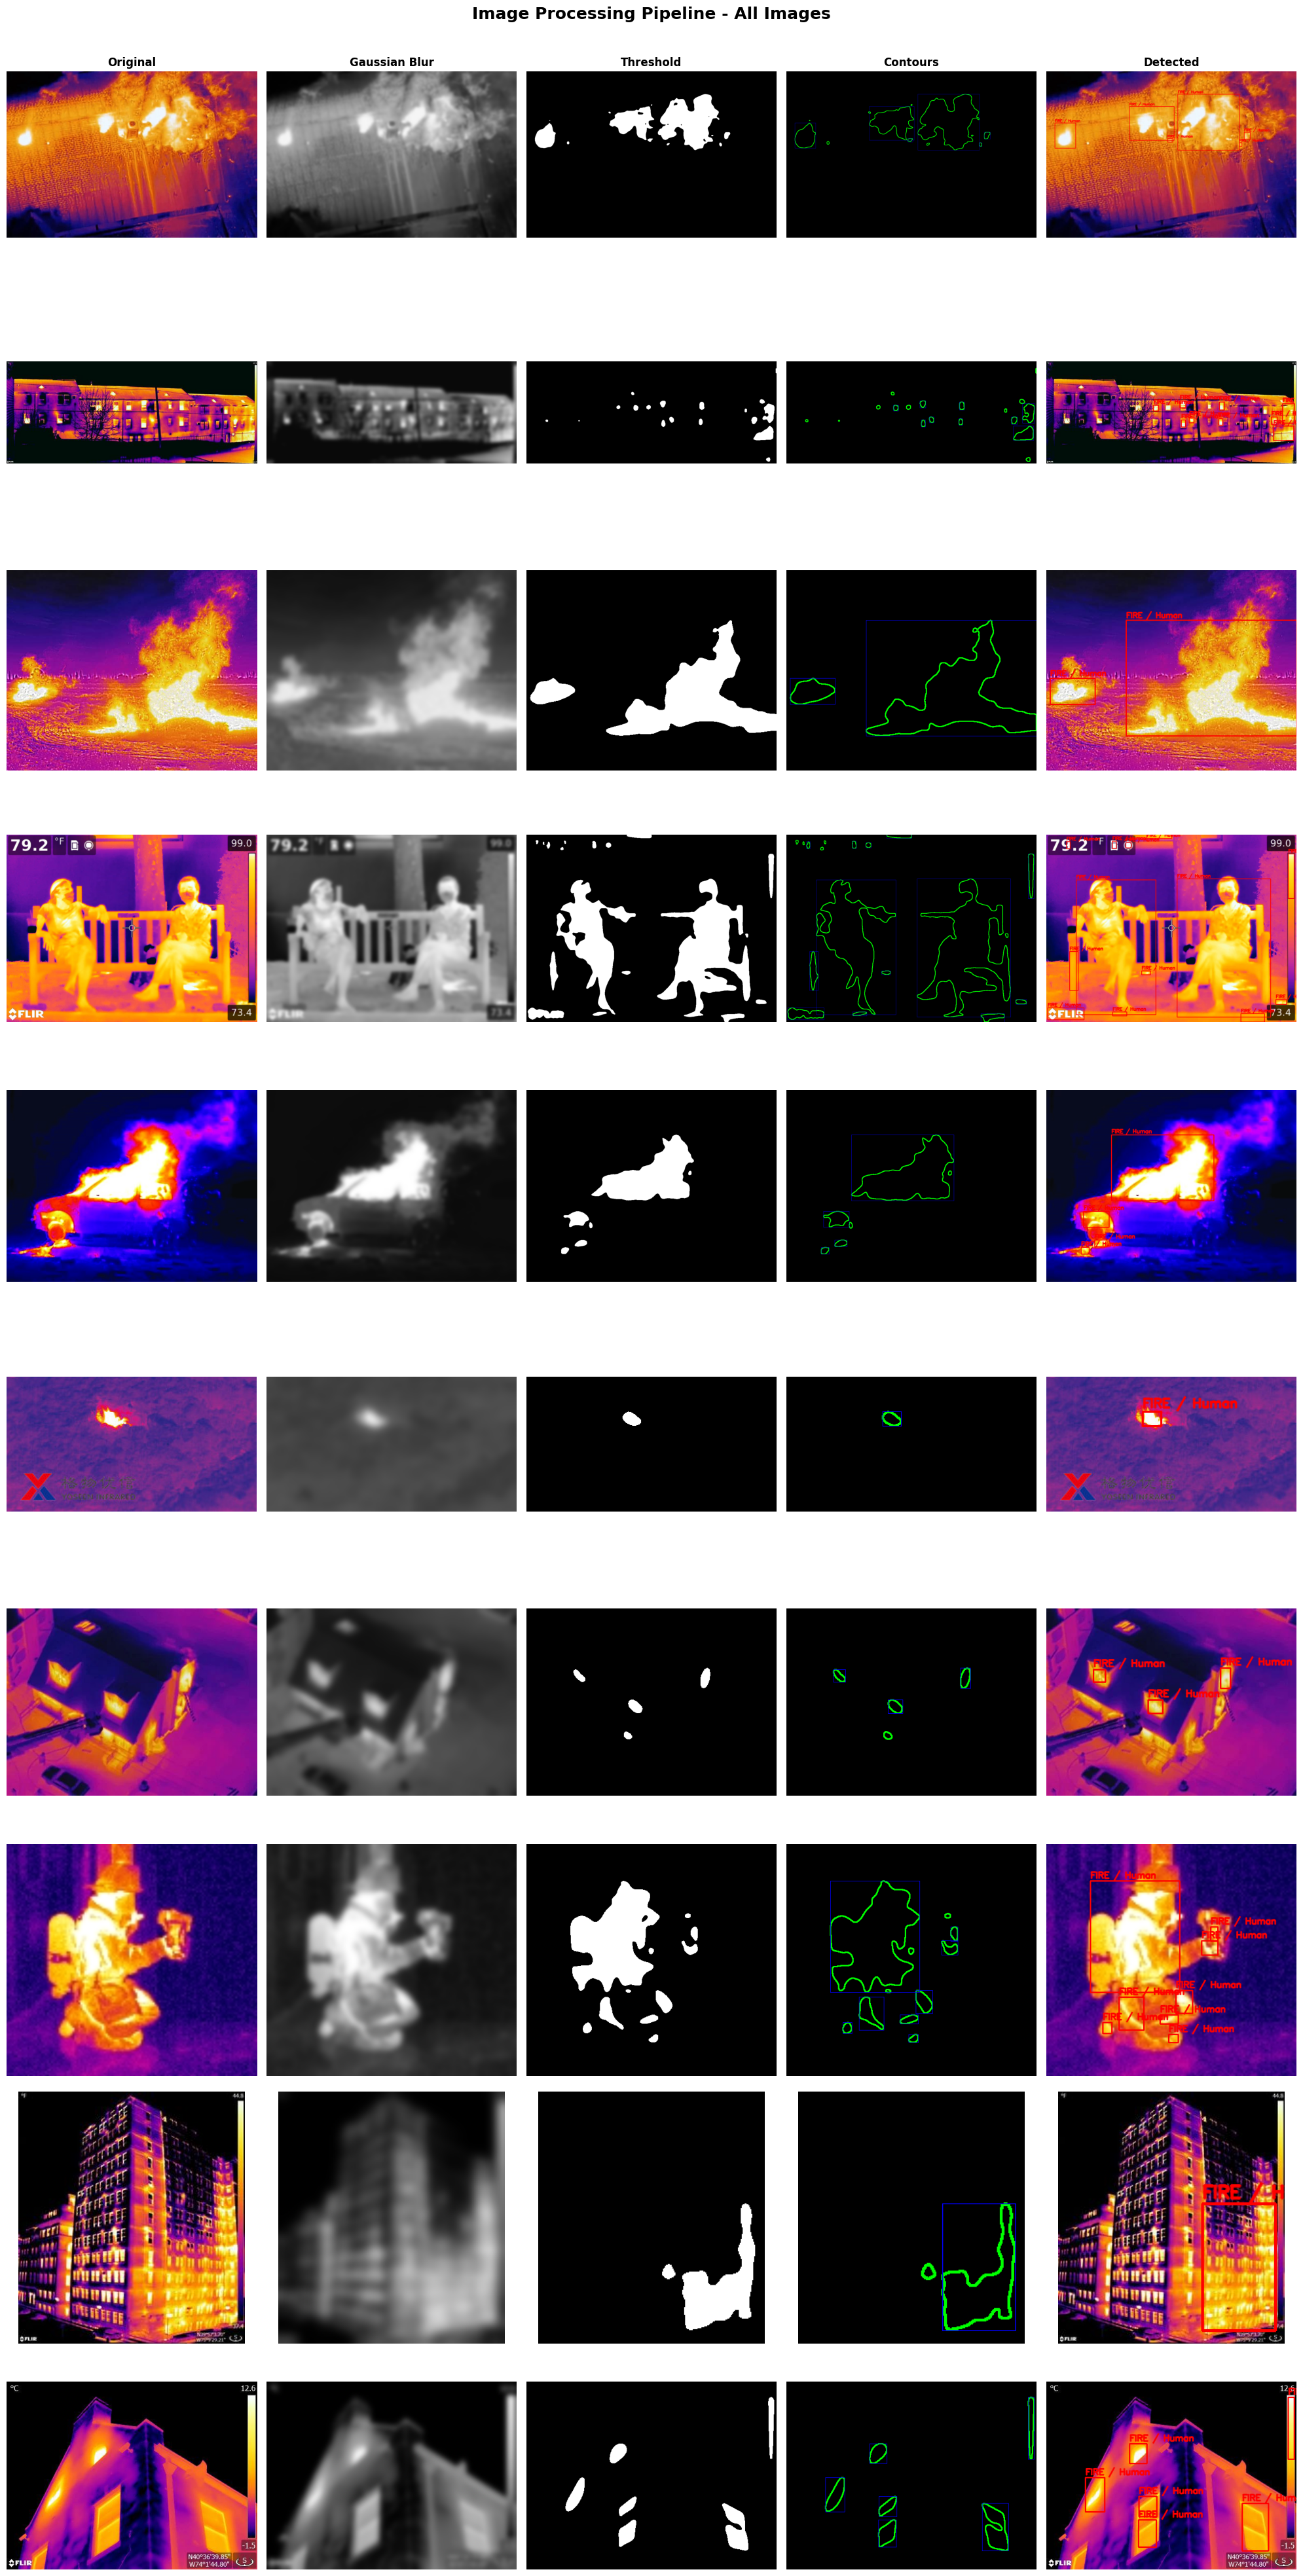


Displayed 10 images in a single panel


In [21]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

def process_image(input_filename):
	image = cv2.imread(input_filename)
	if image is None:
		print(f"Error: failed to read image '{input_filename}'")
		return None

	# Gaussian blur and threshold
	gray_blur = cv2.GaussianBlur(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY), (35, 35), 0)
	_, th = cv2.threshold(gray_blur, 170, 255, cv2.THRESH_BINARY)
	
	# Morphological opening to clean noise
	mask = cv2.morphologyEx(th, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5)))

	# Find and filter contours
	contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
	boxes = []
	for cnt in contours:
		area = cv2.contourArea(cnt)
		if area < 200:
			continue
		x, y, w, h = cv2.boundingRect(cnt)
		boxes.append((x, y, w, h))

	# Create visualization panels
	display_blur = cv2.cvtColor(gray_blur, cv2.COLOR_GRAY2BGR)
	display_th = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
	
	# Contour visualization
	display_contour = np.zeros_like(image)
	cv2.drawContours(display_contour, contours, -1, (0, 255, 0), 2)
	for x, y, w, h in boxes:
		cv2.rectangle(display_contour, (x, y), (x + w, y + h), (255, 0, 0), 1)
	
	# Detection visualization
	display_fire = image.copy()
	for x, y, w, h in boxes:
		cv2.rectangle(display_fire, (x, y), (x + w, y + h), (0, 0, 255), 2)
		cv2.putText(display_fire, "FIRE / Human", (x, max(y - 6, 10)), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2, cv2.LINE_AA)

	# Convert BGR to RGB for matplotlib
	panels = [
		cv2.cvtColor(image, cv2.COLOR_BGR2RGB),
		cv2.cvtColor(display_blur, cv2.COLOR_BGR2RGB),
		cv2.cvtColor(display_th, cv2.COLOR_BGR2RGB),
		cv2.cvtColor(display_contour, cv2.COLOR_BGR2RGB),
		cv2.cvtColor(display_fire, cv2.COLOR_BGR2RGB)
	]
	
	return panels, os.path.basename(input_filename)


def main():
	photos_dir = "Photos"
	
	# Get all image files from Photos directory
	if not os.path.exists(photos_dir):
		print(f"Error: '{photos_dir}' directory not found")
		return
	
	image_files = [f for f in os.listdir(photos_dir) 
	               if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]
	
	if not image_files:
		print(f"No image files found in '{photos_dir}' directory")
		return
	
	image_files.sort()
	num_images = len(image_files)
	print(f"Found {num_images} images in '{photos_dir}' directory\n")
	
	titles = ['Original', 'Gaussian Blur', 'Threshold', 'Contours', 'Detected']
	
	# Collect all results first
	all_results = []
	for idx, filename in enumerate(image_files, 1):
		filepath = os.path.join(photos_dir, filename)
		print(f"[{idx}/{num_images}] Processing: {filename}")
		
		result = process_image(filepath)
		if result is not None:
			all_results.append(result)
	
	if not all_results:
		print("No images were successfully processed")
		return
	
	# Create single figure with all images in rows
	fig, axes = plt.subplots(len(all_results), 5, figsize=(20, 4 * len(all_results)))
	fig.suptitle('Image Processing Pipeline - All Images', fontsize=18, fontweight='bold', y=0.995)
	
	# Handle single image case (axes won't be 2D)
	if len(all_results) == 1:
		axes = [axes]
	
	# Display all images
	for row_idx, (panels, basename) in enumerate(all_results):
		for col_idx, (panel, title) in enumerate(zip(panels, titles)):
			ax = axes[row_idx][col_idx]
			ax.imshow(panel)
			# Add column title only on first row
			if row_idx == 0:
				ax.set_title(title, fontsize=12, fontweight='bold')
			# Add image filename on first column
			if col_idx == 0:
				ax.set_ylabel(basename, fontsize=10, rotation=0, labelpad=50, ha='right')
			ax.axis('off')
	
	plt.tight_layout()
	plt.show()
	print(f"\nDisplayed {len(all_results)} images in a single panel")

if __name__ == "__main__":
	main()